RECOMENDADOR SPOTIFY

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model, save_model
import h5py
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

/home/hacker/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-02-20 17:17:05.686313: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 17:17:05.688455: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 17:17:05.714741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 17:17:05.714770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Atte

**Artist_0** Main Artist

**Duration_sec** Duration_secTrack length in seconds

**Label** The label associated with the album.

**Track_number**: The number of the track. If an album has several discs, the track number is the number on the specified disc.


**Artist_popularity** The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular.

**Followers** The total number of followers for main artist.

**Genre_0** Main Genre

**Acousticness** A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

**Danceability** Danceability describes how suitable a track is for dancing based on a combination of musical elements

**Energy** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.

**Instrumentalness** Predicts whether a track contains no vocals

**Key** The key the track is in. Integers map to pitches using standard Pitch

**Liveness** Detects the presence of an audience in the recording.

**Loudness** The overall loudness of a track in decibels (dB).

**Mode** Mode indicates the modality (major or minor) of a track

**Tempo** The overall estimated tempo of a track in beats per minute (BPM)

**Time_signature** An estimated time signature.

**Valence** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.

**Track_popularity** The popularity of a track is a value between 0 and 100, with 100 being the most popular.

In [2]:
spotify_features_data = pd.read_csv("Data/spotify_data_12_20_2023.csv")

/tmp/ipykernel_20046/1945078820.py:1: DtypeWarning: Columns (25,26,44) have mixed types. Specify dtype option on import or set low_memory=False.
  spotify_features_data = pd.read_csv("Data/spotify_data_12_20_2023.csv")


In [3]:
spotify_features_data.isnull().sum()

album_id                  0
album_name                1
album_popularity          0
album_type                0
artists                   0
artist_0                  2
artist_1             288062
artist_2             336841
artist_3             361318
artist_4             369054
artist_id                 0
duration_sec              0
label                    52
release_date             22
total_tracks              0
track_id                  0
track_name                5
track_number              0
artist_genres             0
artist_popularity         0
followers                 0
name                      0
genre_0              165278
genre_1              255655
genre_2              297922
genre_3              326531
genre_4              343824
acousticness            777
analysis_url            777
danceability            777
duration_ms             777
energy                  777
instrumentalness        777
key                     777
liveness                777
loudness            

### Analizamos las distintas columnas que contiene el DataFrame

In [4]:
# Visualizar las primeras filas del DataFrame
print("Primeras filas del DataFrame:\n", spotify_features_data.head(3), "\n")

# Comprobamos la información el DataFrame
print("Información del DataFrame:\n")
print(spotify_features_data.info(), "\n")

# Descripción estadística de las columnas numéricas
print("Descripción estadística:\n", spotify_features_data.describe(), "\n")

# Contamos los valores faltantes por columna
print("Valores faltantes por columna:\n", spotify_features_data.isna().sum())

Primeras filas del DataFrame:
                  album_id   album_name  album_popularity album_type  \
0  4zH8bbEjLe0Gdbv2FVLjnK  Son Of Tabu                 1      album   
1  4zH8bbEjLe0Gdbv2FVLjnK  Son Of Tabu                 1      album   
2  4zH8bbEjLe0Gdbv2FVLjnK  Son Of Tabu                 1      album   

              artists artist_0  artist_1 artist_2 artist_3 artist_4  ...  \
0              ['AB']       AB       NaN      NaN      NaN      NaN  ...   
1  ['AB', '22nd Jim']       AB  22nd Jim      NaN      NaN      NaN  ...   
2     ['AB', 'Veeze']       AB     Veeze      NaN      NaN      NaN  ...   

  time_signature                                         track_href  \
0            4.0  https://api.spotify.com/v1/tracks/5JucnTkqh8uC...   
1            4.0  https://api.spotify.com/v1/tracks/4VWrKNG3ssyZ...   
2            4.0  https://api.spotify.com/v1/tracks/6JsVrTLJPSOS...   

             type                                   uri  valence explicit  \
0  audio_features

In [5]:
# Comprobamos los datos unicos de las columnas
spotify_features_data.nunique()

album_id              67991
album_name            61467
album_popularity         99
album_type                2
artists               66002
artist_0              35112
artist_1              24641
artist_2               9567
artist_3               3828
artist_4               1756
artist_id             31699
duration_sec         138290
label                 29638
release_date           7503
total_tracks            151
track_id             375141
track_name           275523
track_number             50
artist_genres          5993
artist_popularity        94
followers             12001
name                  30948
genre_0                3008
genre_1                1740
genre_2                 955
genre_3                 524
genre_4                 301
acousticness           5242
analysis_url         374364
danceability           1327
duration_ms          137997
energy                 2918
instrumentalness       5402
key                      12
liveness               1769
loudness            

In [6]:
#album_id es un object, 375141 valores, 0 nans, dentro de los 375141 valores hay 67991 unicos, este es el total de albums que tenemos. 307150 valores repetidos
#es el id del album de spoti

spotify_features_data["album_id"].value_counts()

album_id
2EHUlDJaTyvn0gAvVfUlcY    50
7yS8FoMCF2XSiJK2DWYYci    50
55RhFRyQFihIyGf61MgcfV    50
7iI1y8RwGzaXWxzuHsrbDM    50
6s1DWmUCmFjzD09SRdnfVH    50
                          ..
6A1L3hSVjljVh5yOseAzKt     1
4EtZ8h7dF6bZwiYgxGx1Yi     1
6pFdjrYa5MYXHFRzEZsOkK     1
5rtD0lXzuAoTkIoj5uq5ud     1
4l5hyndJX8PMEkGUXP5kOm     1
Name: count, Length: 67991, dtype: int64

In [7]:
#album_name, object, 375141 valores, 0 nans, 61468 valores unicos, 313673 repetidos
# ¿Este dato no deberia ser igual a album_id?

spotify_features_data["album_name"].value_counts()

album_name
Nirvana                                         707
Exodus                                          489
Action                                          385
Future                                          367
Bach: St. John Passion                          305
                                               ... 
Anti-Hero (Acoustic Version)                      1
Christmas Tree Farm (Old Timey Version)           1
You'Re Losing Me (From The Vault)                 1
Love Story (Taylor'S Version) [Elvira Remix]      1
Lover (First Dance Remix)                         1
Name: count, Length: 61467, dtype: int64

In [8]:
#album_popularity, entero, dato numerico, 375141 valores, no Nans, valores que van del 0 al 100, 
#Album más popular, más cercano a 100, más popular.

spotify_features_data["album_popularity"].value_counts()

album_popularity
0      74198
1      34489
2      20297
3      15216
4      11668
       ...  
100       22
98        21
97        17
90        11
93        10
Name: count, Length: 99, dtype: int64

In [9]:
# album_type, object, 375141 valores, no tiene Nans, hay dos tipos: Album o single

spotify_features_data["album_type"].value_counts()

album_type
album     297589
single     77552
Name: count, dtype: int64

In [10]:
#artists, object, 375141 valores, no tiene Nans, 66002 valores unicos, 309139 valores repetidos
spotify_features_data["artists"].value_counts()

artists
['The Karaoke Channel']                                       1769
["Singer's Edge Karaoke"]                                     1455
['Raphael']                                                   1409
['Johnny Cash']                                               1351
['ProSound Karaoke Band']                                     1285
                                                              ... 
['Yung Gunna Boi', 'Brick Wolfpack']                             1
['Yung Gunna Boi', 'Yung City', 'Peso Peso', 'IDM T Wafe']       1
['Yung Gunna Boi', 'Chief', 'Danny B', 'Luhh Ace']               1
['Yung Gunna Boi', 'Chief Diddy', 'Luhh Ace']                    1
['Acoustic Guitar']                                              1
Name: count, Length: 66002, dtype: int64

In [11]:
#artist_0, object, 375139 valores, 2 Nans, 35112 valores unicos, 340027 valores repetidos
#esta columna hace referencia al artista

spotify_features_data["artist_0"].value_counts()

artist_0
Johann Sebastian Bach    2483
Johnny Cash              1792
The Karaoke Channel      1769
Raphael                  1519
Singer's Edge Karaoke    1455
                         ... 
İsa İçen                    1
Poncho Y Javi               1
Wyatt Coleman               1
VANITAS命死                   1
4ep YungMuny                1
Name: count, Length: 35112, dtype: int64

In [12]:
#artist_1, object, 87079 valores, 288062 Nans, 24641 valores unicos, 62438 repetidos
# esta columna hace referencia a canciones que cantan dos artistas, esto significa que hay 87079 con dos artistas, por ejemplo una cancion del album Son Of Tabu es cantado por 'AB' y'Veeze'
#valores repetidos es la cantidad total de artistas que cantan juntos varios temas

spotify_features_data["artist_1"].value_counts()

artist_1
Sound Healing Center                      1445
Choir of St. John's College, Cambridge     764
Trap House Mafia                           453
Snoop Dogg                                 410
Lil Wayne                                  343
                                          ... 
Kendo Kaponi                                 1
Mambo Kingz                                  1
Quimico Ultra Mega                           1
Gabriela                                     1
Eladio Carrion                               1
Name: count, Length: 24641, dtype: int64

In [13]:
#artist_2, object, 38300 valores, 336841 Nans, 9567 valores unicos, 28733 repetidos

spotify_features_data["artist_2"].value_counts()

artist_2
Sound Healing Center                   1300
Hip Hop Type Beat                       453
Andrew Nethsingha                       283
Academy of St. Martin in the Fields     263
New York Philharmonic                   219
                                       ... 
ONSEEON                                   1
Leo Sagrado                               1
Coxenberg                                 1
Twigg                                     1
Kell Kay                                  1
Name: count, Length: 9567, dtype: int64

In [14]:
#artist_3, object, 13823 valores, 361318 valores Nans, 3828 valores unicos, 9995 repetidos

spotify_features_data["artist_3"].value_counts()

artist_3
George Guest                           199
Academy of St. Martin in the Fields    156
Sir Neville Marriner                   137
India Fisher                           133
Maggie Stables                         109
                                      ... 
Mathew                                   1
All Mayan Winik                          1
Juicy J                                  1
Lloyd Banks                              1
Xzibit                                   1
Name: count, Length: 3828, dtype: int64

In [15]:
#artist_4, object, 6087 valores, 369054 nulos, 1756 unicos, 4331 repetidos

spotify_features_data["artist_4"].value_counts()

artist_4
Makoto Sakurada                        86
Mark Padmore                           80
Ingeborg Danz                          71
George Guest                           66
Academy of St. Martin in the Fields    63
                                       ..
Jay Bone                                1
Sha Da God                              1
Huncho                                  1
Arcade D Button                         1
Soul One                                1
Name: count, Length: 1756, dtype: int64

In [16]:
#artist_id, object, 375141 valores, no nulos, 31699 valores unicos, 343442 repetidos 

spotify_features_data["artist_id"].value_counts()

artist_id
5aIqB5nVVvmFsvSdExz408    2292
6kACVPfCOnqzgfEF5ryl0x    1897
5UloVKzUNJcjORzhhTWWiJ    1763
3CtgjasLNN3Ym8SHm5JuJn    1455
2o5jDhtHVPhrJdv3cEQ99Z    1442
                          ... 
1Fx2qQrw6nSIZDe0yr6nGR       1
52KgCdZCBgAse8sC2nscfi       1
0WtuWklruiIIqO5Nwpd5I6       1
3tIgVJ5DZ0RW3N7GM4PHSG       1
2qv1mRVZMyj1EJJdJmrZ7s       1
Name: count, Length: 31699, dtype: int64

In [17]:
#duration_sec, float64, 375141 valores, no nulos, 138290 valores unicos, 236851 repetidos
#el valor que mas se reppite son 120 segundos, hay alguna cancion que no tiene sentido su duracion, por ejemplo, 0 segundos:

spotify_features_data["duration_sec"].value_counts().sort_index()

duration_sec
0.000        2
0.184        1
0.737        1
0.798        1
0.850        1
            ..
5280.026     1
7295.500     1
12813.333    1
17040.000    1
17919.000    1
Name: count, Length: 138290, dtype: int64

In [18]:
# label, object, 375117 valores, 24 nulos,  29639 unicos, 345478 repetidos
#por los resultados que da, entiendo que esta columna se refiere al sello discografico.

spotify_features_data["label"].value_counts()

label
Sami Springs                   3395
CC Entertainment               3197
Columbia                       2316
Legacy Recordings              2058
Ameritz Music Ltd              2040
                               ... 
Two Records                       1
MEME TOKYO / TOY'S FACTORY        1
Plaid Robot Recordings, LLC       1
Dhoven Gards                      1
Emone Skillz                      1
Name: count, Length: 29638, dtype: int64

In [19]:
#release_date, object, 375119 valores, 22 nulos, 7503 unicos, 367616 repetidos
# fecha de lanzamiento, la mas repetida es el 1/01/2008 y la mas antigua el 1/01/1886??, la mas reciente el 22/12/23

spotify_features_data["release_date"].value_counts().sort_index()

release_date
1886-01-01 00:00:00 UTC     4
1899-12-30 00:00:00 UTC    20
1900-01-01 00:00:00 UTC    14
1901-01-01 00:00:00 UTC    50
1912-01-01 00:00:00 UTC    13
                           ..
2023-12-16 00:00:00 UTC    20
2023-12-17 00:00:00 UTC    33
2023-12-19 00:00:00 UTC     1
2023-12-20 00:00:00 UTC    14
2023-12-22 00:00:00 UTC     2
Name: count, Length: 7503, dtype: int64

In [20]:
# total_tracks, entero, 375141 valores, no tiene Nans, 151 unicos, 374990 repetidos

spotify_features_data["total_tracks"].value_counts()

total_tracks
1      34736
10     30071
12     27286
11     19864
14     18289
       ...  
214       50
239       50
229       50
104       50
150       50
Name: count, Length: 151, dtype: int64

In [21]:
#track_id, object, 375141, valores, no Nnas, 375141 unicos, no valores repetidos

spotify_features_data["track_id"].value_counts()

track_id
6WZgeIZgy7iFSC25chloVu    1
5JucnTkqh8uCZGggL1xxvv    1
4VWrKNG3ssyZeboTgQ7Kj1    1
6JsVrTLJPSOSpgJSnZyfSK    1
7pZpw1xJWIavCUGqXPPriP    1
                         ..
4IzFhRLg0qK0XSpodSaNBH    1
21EP4aM1ASi5fn43gPNes1    1
5a4pBckTf3A0fXRwYRgi5p    1
33vNTbQNZ3p6YGc876hAs1    1
7wLWcD3FBZmpONLr8DkAKl    1
Name: count, Length: 375141, dtype: int64

In [22]:
#track_name, object, 375139 valores, 2 nulos,  275524 unicos, 99615 repetidos

spotify_features_data["track_name"].value_counts()

track_name
Intro                                                                      511
Outro                                                                      161
Home                                                                        98
Stay                                                                        94
Silent Night                                                                92
                                                                          ... 
I Can See You (Taylor’S Version) (From The Vault)                            1
White Horse - Instrumental With Bgv                                          1
Electric Touch (Feat. Fall Out Boy) (Taylor’S Version) (From The Vault)      1
You Need To Calm Down - Clean Bandit Remix                                   1
Hey Stephen - Commentary                                                     1
Name: count, Length: 275523, dtype: int64

In [23]:
#track_number, enteros, 375141, no Nnas, 50 valores uniso, 375091 repetidos
#valores de 1 al 50. SI me meto dentro del album de spotify, que posicion ocupa la canción. SIgue un patrón, la mas escuchada es la que aparece de numero 1 y la menos la 50

spotify_features_data["track_number"].value_counts()

track_number
1     67976
2     33415
3     28501
4     25982
5     24210
6     22584
7     20984
8     19807
9     18280
10    16943
11    13811
12    11925
13     9518
14     8076
15     6664
16     5464
17     4540
18     3945
19     3365
20     2980
21     2343
22     2083
23     1814
24     1661
25     1497
26     1342
27     1194
28     1135
29     1060
30     1017
31      858
32      810
33      743
34      705
35      667
36      630
37      602
38      586
39      571
40      548
41      481
42      476
43      457
44      444
45      442
46      423
47      414
48      397
49      392
50      379
Name: count, dtype: int64

In [24]:
#artist_genres, object, 375141 valores, no Nans, 5993 unicos, 369148 repetidos.
#Ojo aquí hay 1650278 valores que aparecen en blanco.
# Tenemos 209863 que realmente están etiquetados. 
#entiendo que los valores en blanco es porque no están etiquetados dentro de spoti.
#Ojo, un artista puede estar etiquetado dentro de varios generos.

spotify_features_data["artist_genres"].value_counts()

artist_genres
[]                                                           165278
['karaoke']                                                   15344
['baroque', 'classical', 'early music', 'german baroque']      2292
['workout product']                                            2039
['arkansas country', 'outlaw country', 'rock']                 1897
                                                              ...  
['cornwall indie']                                                1
['renaissance', 'spanish renaissance']                            1
['hong kong tv drama']                                            1
['black punk']                                                    1
['turkmen pop']                                                   1
Name: count, Length: 5993, dtype: int64

In [25]:
375141 - 165278 #estos son los datos que nos quedariamos si eliminamos lo que quedan en blanco

209863

In [26]:
#artist_popularity, int, 375141 valores, no Nans, 94 valores unicos, 375047 repetidos
#Los valores comprenden entre el 0-100, más cercano a 100, más popular el artista.

spotify_features_data["artist_popularity"].value_counts().sort_index()

artist_popularity
0      46397
1      16746
2      10475
3       8447
4       8699
       ...  
89      1009
90       403
93       407
95       785
100      938
Name: count, Length: 94, dtype: int64

In [27]:
# followers, int, 375141 valores, 12001 valores unicos, no Nans, 363140 valores repetidos
# Hay 3009 datos que aparecen con 0 followers
# Mas escuchado es nirvana.

spotify_features_data["followers"].value_counts().sort_index()

followers
0            3009
1            2001
2            1713
3            1467
4            1539
             ... 
95741850       18
95859165      938
115998928       6
116016052       6
116035640       2
Name: count, Length: 12001, dtype: int64

In [28]:
#name, object, 375141 valores, no Nans, 30948 valores unicos, 344193 valores repetidos

spotify_features_data["name"].value_counts()

name
Johann Sebastian Bach    2292
Johnny Cash              1897
The Karaoke Channel      1763
Raphael                  1521
Singer's Edge Karaoke    1455
                         ... 
Rapper Big Deal             1
The Third-Rates             1
Alessandra Arena            1
Anthony & Jeremy            1
Cherry Moon Trax            1
Name: count, Length: 30948, dtype: int64

In [29]:
# genre_0, object, 209863 valores, 165278Nans, 3008 valores unicos, 206855 repetidos

spotify_features_data["genre_0"].value_counts().sort_values()

genre_0
odia pop                   1
rap sergipano              1
malaysian tamil rap        1
dweilorkest                1
slc indie                  1
                       ...  
baroque                 3421
album rock              3707
classical               3848
dance pop               4496
karaoke                15344
Name: count, Length: 3008, dtype: int64

In [30]:
209863 - 165278 #estos son el numero total de datos que nos quedariamos si eliminasemos los nan de nenero

44585

In [31]:
#genre_1,2,3 y 4 abarcan mas de un genero.

In [32]:
#acousticness, float, 374364 valores, 777 Nans, 5242 valores unicos, 369122 repetidos
#Variable que va de 0 a 1, indica nivel de confianza de que la cancion sea acustica.

spotify_features_data["acousticness"].value_counts()

acousticness
0.995000    2007
0.994000    1688
0.993000    1644
0.992000    1605
0.991000    1356
            ... 
0.000009       1
0.000003       1
0.000010       1
0.000008       1
0.000010       1
Name: count, Length: 5242, dtype: int64

In [33]:
#analysis_url, object, 374364 valores, 777 Nans, 374364 unicos, no valores repetidos.

spotify_features_data["analysis_url"].value_counts()

analysis_url
https://api.spotify.com/v1/audio-analysis/6WZgeIZgy7iFSC25chloVu    1
https://api.spotify.com/v1/audio-analysis/5JucnTkqh8uCZGggL1xxvv    1
https://api.spotify.com/v1/audio-analysis/4VWrKNG3ssyZeboTgQ7Kj1    1
https://api.spotify.com/v1/audio-analysis/6JsVrTLJPSOSpgJSnZyfSK    1
https://api.spotify.com/v1/audio-analysis/7pZpw1xJWIavCUGqXPPriP    1
                                                                   ..
https://api.spotify.com/v1/audio-analysis/5oqTUCIkhzjkmvhj1ZMkMz    1
https://api.spotify.com/v1/audio-analysis/7CPhQbX7GxiSOH5hBC69SW    1
https://api.spotify.com/v1/audio-analysis/4vTzuIgQa5Mfof1nrFiDRQ    1
https://api.spotify.com/v1/audio-analysis/7yHXvLEzrVHrIytPhY0RiJ    1
https://api.spotify.com/v1/audio-analysis/5JgoLJ5o0EPeynIIGPNjtM    1
Name: count, Length: 374364, dtype: int64

In [34]:
#danceability, float, 374364 valores, 777 Nans, 1327 unicos, 373037 repetidos.
#Valores que van del 0 al 1 e indican cuanto de bailable es una cancion.

spotify_features_data["danceability"].value_counts().sort_index()


danceability
0.0000    546
0.0167      1
0.0236      1
0.0492      1
0.0532      1
         ... 
0.9880      7
0.9890      3
0.9920      2
0.9930      1
0.9990      1
Name: count, Length: 1327, dtype: int64

In [35]:
#duration_ms, float, 374364 valroes, 777 Nans, 137997 valores unicos, 236367 repetidos
#Indica el tiempo que dura la cancion en milisegundos
spotify_features_data["duration_ms"].value_counts()

duration_ms
120000.0    1585
192000.0     340
240000.0     295
180000.0     272
60000.0      187
            ... 
77833.0        1
55289.0        1
311765.0       1
189509.0       1
62377.0        1
Name: count, Length: 137997, dtype: int64

In [36]:
#energy, float, 374364 valores, 777 Nans, 2918 valores unicos, 371446 repetidos
# Valores del 0 al 1.
#Indica la energía de la canción, más proximo a 1 más energía tiene la cancion, más proximo a 0 menos,
spotify_features_data["energy"].value_counts()

energy
0.539000    568
0.640000    566
0.562000    554
0.662000    547
0.528000    546
           ... 
0.000638      1
0.007910      1
0.000020      1
0.000245      1
0.000126      1
Name: count, Length: 2918, dtype: int64

In [37]:
#instrumentalness, float, 374364 valores, 777 Nans, 5402 unicos, 368962 repetidos.
# Valores del 0 al 1.
# Valores más cercanos a 1 indican que la cancion es mas instrumental y los mas cercanos a 0, menos intriçumental.

spotify_features_data["instrumentalness"].value_counts()

instrumentalness
0.000000    108294
0.932000       674
0.910000       655
0.915000       652
0.925000       646
             ...  
0.008750         4
0.009670         4
0.008450         3
0.009930         3
0.000096         3
Name: count, Length: 5402, dtype: int64

In [38]:
#  key, float, 374364 valores, 777 key, 12 valores unicos, 374352 repetidos
# valores que van del 0 al 11 
#Canciones con bajo key suenan más graves, mientras que con alto key suenan más agudos.
spotify_features_data["key"].value_counts().sort_index()

key
0.0     43670
1.0     39389
2.0     37951
3.0     12874
4.0     27586
5.0     31666
6.0     23403
7.0     42404
8.0     24049
9.0     36151
10.0    26971
11.0    28250
Name: count, dtype: int64

In [39]:
#liveness, float, 374364 valores, 777 Nans, 1769 unicos, 372595 repetidos.
#Valores del 0 a 1
#Indica la probabilidad de que la cancion haya sido grabada en vivo. Valores mas cercanos a 1 mas probable en vivo.
spotify_features_data["liveness"].value_counts()

liveness
0.11100    5634
0.11000    5101
0.10900    4783
0.11200    4600
0.10800    4574
           ... 
0.01370       1
0.02010       1
0.00909       1
0.01510       1
0.00936       1
Name: count, Length: 1769, dtype: int64

In [40]:
#loudness, float, 374364 valores, 777 Nans, 32916 valores unicos, 341448 repetidos.
#valores que van de -60 a 3.
#La presencia de ruido en decibeles (dB), 
#este valor es el promedio de la cancion

spotify_features_data["loudness"].value_counts().sort_index()

loudness
-60.000    23
-58.780     1
-58.188     1
-57.929     1
-57.579     1
           ..
 2.801      1
 2.853      1
 2.868      1
 3.053      1
 3.744      1
Name: count, Length: 32916, dtype: int64

In [41]:
#mode, float, 374364 valores, 777 Nans, 2 valores unicos.
# valores de 0 y 1
# Indica la modalidad (mayor o menor) de una canción, el tipo de escala del que se deriva su contenido melódico. La mayor se representa con 1 y la menor con 0.

spotify_features_data["mode"].value_counts()

mode
1.0    238837
0.0    135527
Name: count, dtype: int64

In [42]:
#speechiness, float, 374364 valores, 777 Nans, 1653 unicos, 372711 iguales.
#elementos de 0 a 1
#inidca la presencia de palabras, mayores palabras puede indicar que se trata de un audiolibro, podcast etc.

spotify_features_data["speechiness"].value_counts().sort_index()

speechiness
0.0000    545
0.0217      1
0.0218      1
0.0221      2
0.0222      2
         ... 
0.9660     45
0.9670     37
0.9680     17
0.9690      1
0.9700      2
Name: count, Length: 1653, dtype: int64

In [43]:
#tempo, float, 374364 valores, 777 Nans, 101940 unicos, 272424 diferentes.
#indica la velocidad de una cancion.

spotify_features_data["tempo"].value_counts()

tempo
0.000      545
120.001    139
120.008    133
119.999    125
120.003    123
          ... 
62.327       1
150.361      1
88.490       1
135.503      1
98.211       1
Name: count, Length: 101940, dtype: int64

In [44]:
#time_signature, float, 374364 valores, 777 Nans, 5 unicso.
#Indica La notación convencional que indica cuantos beats hay en cada bar. Se escriben únicamente los numeradores, ya que el denominador es 4. Por ejemplo, "4/4" o "7/4"

spotify_features_data["time_signature"].value_counts()

time_signature
4.0    317462
3.0     40062
5.0     11004
1.0      5288
0.0       548
Name: count, dtype: int64

In [45]:
#track_href, object, 374364 valores, 777 Nans, 374364 son todos lçvaloers unicos.

spotify_features_data["track_href"].value_counts()

track_href
https://api.spotify.com/v1/tracks/6WZgeIZgy7iFSC25chloVu    1
https://api.spotify.com/v1/tracks/5JucnTkqh8uCZGggL1xxvv    1
https://api.spotify.com/v1/tracks/4VWrKNG3ssyZeboTgQ7Kj1    1
https://api.spotify.com/v1/tracks/6JsVrTLJPSOSpgJSnZyfSK    1
https://api.spotify.com/v1/tracks/7pZpw1xJWIavCUGqXPPriP    1
                                                           ..
https://api.spotify.com/v1/tracks/5oqTUCIkhzjkmvhj1ZMkMz    1
https://api.spotify.com/v1/tracks/7CPhQbX7GxiSOH5hBC69SW    1
https://api.spotify.com/v1/tracks/4vTzuIgQa5Mfof1nrFiDRQ    1
https://api.spotify.com/v1/tracks/7yHXvLEzrVHrIytPhY0RiJ    1
https://api.spotify.com/v1/tracks/5JgoLJ5o0EPeynIIGPNjtM    1
Name: count, Length: 374364, dtype: int64

In [46]:
#type, object, 374364 valores, 777 Nans, 1 valor unico.

spotify_features_data["type"].value_counts()

type
audio_features    374364
Name: count, dtype: int64

In [47]:
#uri, object, 374364 valores, 777 Nans, 374364 unicos (todo valores unicos)

spotify_features_data["uri"].value_counts()

uri
spotify:track:6WZgeIZgy7iFSC25chloVu    1
spotify:track:5JucnTkqh8uCZGggL1xxvv    1
spotify:track:4VWrKNG3ssyZeboTgQ7Kj1    1
spotify:track:6JsVrTLJPSOSpgJSnZyfSK    1
spotify:track:7pZpw1xJWIavCUGqXPPriP    1
                                       ..
spotify:track:5oqTUCIkhzjkmvhj1ZMkMz    1
spotify:track:7CPhQbX7GxiSOH5hBC69SW    1
spotify:track:4vTzuIgQa5Mfof1nrFiDRQ    1
spotify:track:7yHXvLEzrVHrIytPhY0RiJ    1
spotify:track:5JgoLJ5o0EPeynIIGPNjtM    1
Name: count, Length: 374364, dtype: int64

In [48]:
# valence, float, 374364, 777 Nans, 2043 unicos, 372321 repetidos
#Describe la positividad de la canción. Valores altos indican mayor positividad (alegría, euforia, ánimos) y valores bajos indican más negatividad (tristeza, etc)

spotify_features_data["valence"].value_counts().sort_index()

valence
0.000000     845
0.000010    1278
0.000022       1
0.000087       1
0.000115       1
            ... 
0.996000       5
0.997000       7
0.998000       3
0.999000       6
1.000000      23
Name: count, Length: 2043, dtype: int64

In [49]:
#explicit, object, 375131 valores, 10 Nans, 2 valores únicos.
#creo que significa contenido explicito (lenguaje ofensivo, insultos...)

spotify_features_data["explicit"].value_counts()

explicit
False    316732
True      58399
Name: count, dtype: int64

In [50]:
#track_popularity, float, 375131 valores, 10 Nans, 100 valores unicos
#valores del 0 al 100, siendo 100 el más popular . La popularidad se calcula mediante un algoritmo y se basa, en su mayor parte, en el número total de reproducciones que ha tenido la pista y en lo recientes que son esas reproduccione

spotify_features_data["track_popularity"].value_counts().sort_index()

track_popularity
0.0     147239
1.0      28123
2.0      17820
3.0      13677
4.0      10675
         ...  
95.0         1
96.0         1
97.0         1
98.0         1
99.0         2
Name: count, Length: 100, dtype: int64

In [51]:
# release_year, float , 375119 valores, 22 Nans, 85 unicas
# año de lanzamiento, siendo 1886 la mas antigua y 2023 la mas reciente.

spotify_features_data["release_year"].value_counts()

release_year
2023.0    58986
2022.0    36940
2021.0    25990
2020.0    24261
2019.0    18842
          ...  
1942.0       11
1954.0       10
1929.0        7
1948.0        6
1886.0        4
Name: count, Length: 85, dtype: int64

In [52]:
#release_month, object, 375119 valores, 22 Nans, 12 valores unicos
#mes de lanzamiento

spotify_features_data["release_month"].value_counts()

release_month
January      63888
November     36295
October      34846
September    30097
July         28528
June         27756
August       27429
March        27044
May          26022
April        25698
December     25017
February     22499
Name: count, dtype: int64

In [53]:
#rn, int, 375141 valores 0 Nans, 1 dato unico

spotify_features_data["rn"].value_counts()

rn
1    375141
Name: count, dtype: int64

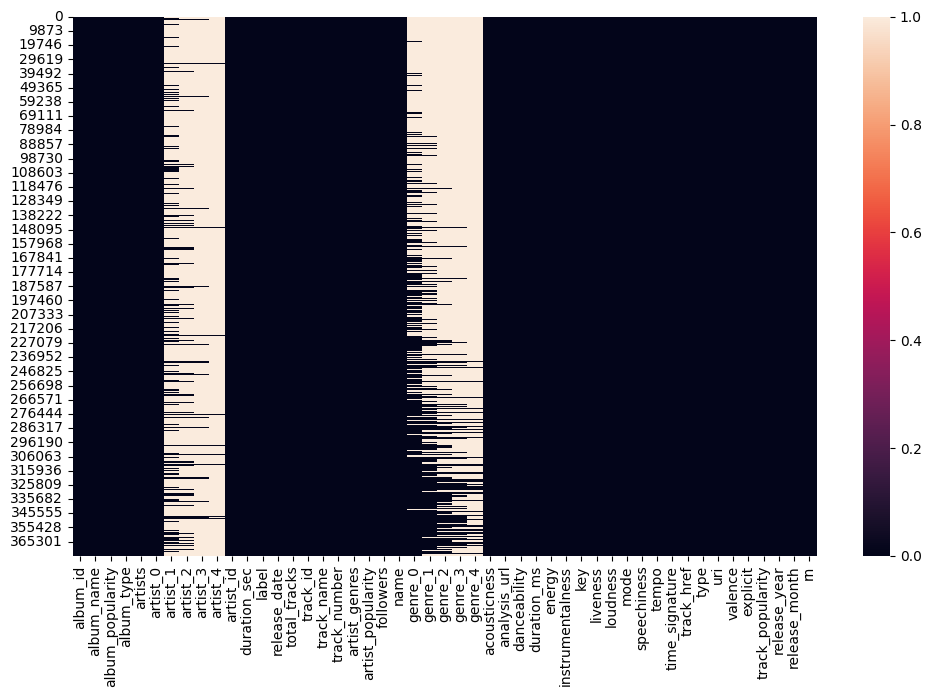

In [54]:
# Graficamos los NaN:

plt.figure(figsize = (12,7))
sns.heatmap(spotify_features_data.isna())
plt.savefig('grafica_nan.png')
plt.show()



### Comenzamos a modificar el DataFrame según las conclusiones tras observar las variables

In [55]:
# Decidimos que las columnas relevantes son las siguientes: 
columnas_relevantes = ['album_id', 'album_name', 'album_popularity', 'genre_0',
                       'album_type', 'artists', 'artist_id', 'duration_sec', 
                       'track_id', 'track_name', 'artist_genres', 'artist_popularity', 
                       'name', 'acousticness', 'danceability', 'energy', 
                       'instrumentalness', 'key', 'liveness', 'loudness', 
                       'mode', 'speechiness', 'tempo', 'time_signature', 
                       'uri', 'valence', 'explicit', 'track_popularity', 'followers']

# Creamos una copia con las columnas relevantes y sin nan
spotify_features_data_reducido = spotify_features_data[columnas_relevantes].copy().dropna()

spotify_features_data_reducido["artists"] = spotify_features_data_reducido["artists"].apply(lambda x : eval(x)[0].lower())

# Creamos un DataFrame con Artista_id y el nombre del artista con los id unicos
data = pd.DataFrame({"artist_id": spotify_features_data_reducido["artist_id"],
                     "artists" : spotify_features_data_reducido["artists"]})
data = data.drop_duplicates()

# Creamos un DataFrame con los valores no numéricos/ no comparables/relevantes
columnas_objetos = ['album_id', 'album_name', 'duration_sec', 'album_popularity', 'album_type',
                    'artists', 'artist_popularity', 'tempo', 'artist_id', 'track_id', 'track_name', 
                    'artist_genres', 'name', 'uri', 'time_signature', 'explicit', 'track_popularity']
spotify_datos = spotify_features_data_reducido[columnas_objetos].copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13402 entries, 334 to 374832
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artist_id  13402 non-null  object
 1   artists    13402 non-null  object
dtypes: object(2)
memory usage: 314.1+ KB


### Gráfico inicial mostrando followers vs artista

In [56]:
follower_top_inicial = pd.DataFrame({"followers": spotify_features_data_reducido["followers"],
                     "artists" : spotify_features_data_reducido["artists"]})
follower_top_inicial = follower_top_inicial.drop_duplicates("artists")
follower_top_inicial = follower_top_inicial.sort_values(by = "followers", ascending = False)
follower_top_inicial = follower_top_inicial.head(10)

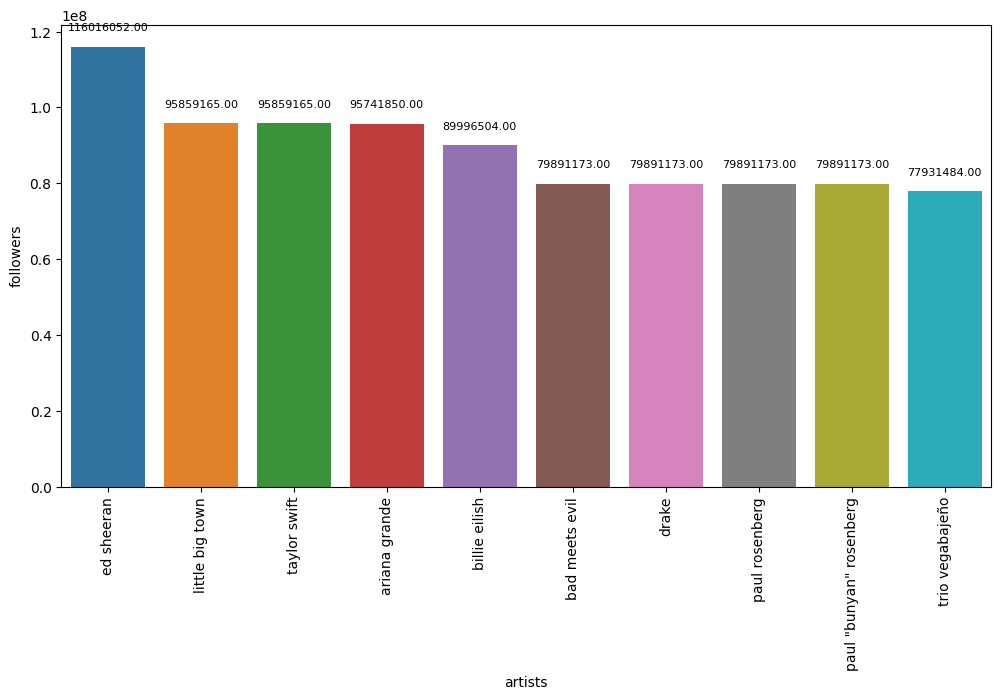

In [57]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='artists', y='followers', data=follower_top_inicial)
plt.xticks(rotation=90)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='bottom',
                   textcoords='offset points', xytext=(0,10),
                   fontsize=8)

plt.show()


### Gráfica popularity vs artista

In [58]:
popularity_top_inicial = pd.DataFrame({"artist_popularity": spotify_features_data_reducido["artist_popularity"],
                     "artists" : spotify_features_data_reducido["artists"]})
popularity_top_inicial = popularity_top_inicial.drop_duplicates("artists")
popularity_top_inicial = popularity_top_inicial.sort_values(by = "artist_popularity", ascending = False)
popularity_top_inicial = popularity_top_inicial.head(10)

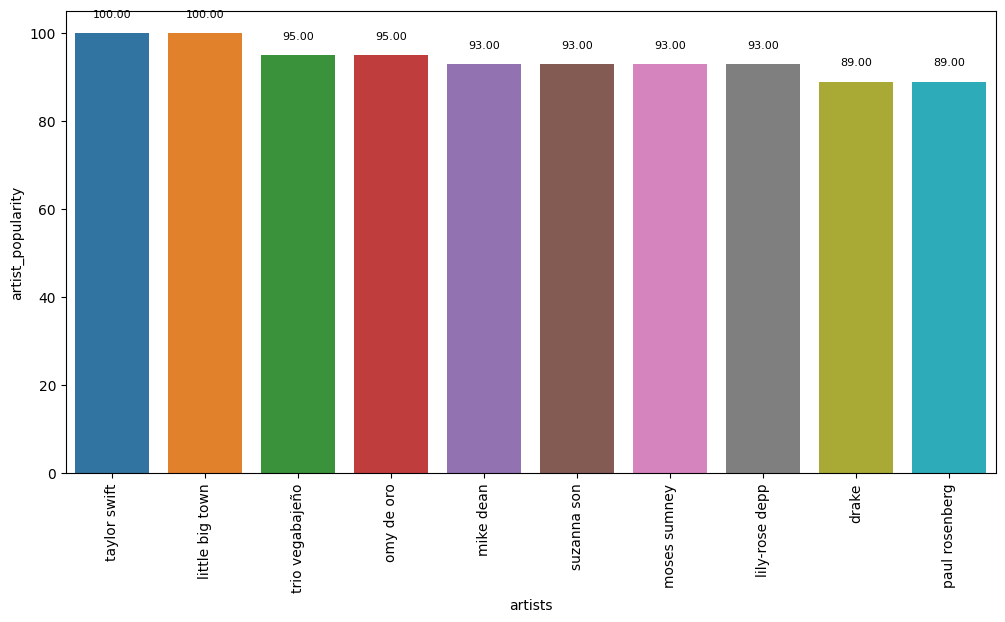

In [59]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='artists', y='artist_popularity', data=popularity_top_inicial)
plt.xticks(rotation=90)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='bottom',
                   textcoords='offset points', xytext=(0,10),
                   fontsize=8)
plt.savefig('popularity vs artista.png')
plt.show()

In [60]:
#Generamos una función para sacar las preferencias del usuario activo
def generador_preferencias():
    
    artistas_puntuacion = list()
    
    while len(artistas_puntuacion) < 5:
        try:
            artista_usuario = input("Por favor, introduce el nombre de un artista/banda: ").strip().lower()

            # Verificar si el artista está en el DataFrame
            if artista_usuario not in spotify_features_data_reducido["artists"].values:
                print("Artista no encontrado. Por favor, intenta con otro nombre.")
                continue

            puntuacion_usuario = int(input("Por favor, introduce la puntuación del artista/banda (1-10): "))

            # Validar que la puntuación está en el rango correcto
            if puntuacion_usuario < 1 or puntuacion_usuario > 10:
                print("La puntuación debe estar entre 1 y 10.")
                continue

            artist_id = spotify_features_data_reducido[spotify_features_data_reducido["artists"] == 
                                                       artista_usuario]["artist_id"].values[0]

            artistas_puntuacion.append([artist_id, puntuacion_usuario])

        except ValueError:
            print("Por favor, introduce un número válido para la puntuación.")
        except IndexError:
            print("Hubo un error al buscar el artista. Por favor, intenta de nuevo.")

    return pd.DataFrame(data=artistas_puntuacion, columns=["artist_id", "score"])

### Datos Aleatorios

In [61]:
import random

In [62]:
# Generamos una saerie de usuarios aleatorios, relacionados con artistas y calificaciones de esos artistas

#los usuarios
n_usuarios = random.randint(10_000, 20_000)

usuarios_id = [f"userid_{x}" for x in range(n_usuarios)]

artist_id_list = data["artist_id"].tolist()

data_usuarios = list()
#puntuaciones de canciones de los usuarios generados
for uid in usuarios_id:
    
    for i in range(random.randint(200, 300)):
        
        data_usuarios.append([uid, random.randint(1, 10), random.choice(seq = artist_id_list)])
        
usuarios = pd.DataFrame(data = data_usuarios, columns = ["user_id", "like", "artist_id"])

In [63]:
usuarios

,user_id,like,artist_id
0,userid_0,9,2vf4pRsEY6LpL5tKmqWb64
1,userid_0,2,56MsGGbdOtGbcSoOKc5N7V
2,userid_0,2,0k5KeG8St6LiePh5blOwwl
3,userid_0,5,5FKABVMDKiED2mhi8bFSVx
4,userid_0,4,6bwp9ObI8FWvMPCIWVBmhl
...,...,...,...
4381883,userid_17522,2,3tJoFztHeIJkJWMrx0td2f
4381884,userid_17522,5,6RsLLSkSTcL4YrvgRcBTQd
4381885,userid_17522,10,0nKUfjTYVwxM6hZrvKhlNU
4381886,userid_17522,7,64Bnlany1OG6esdJyOxyey


In [64]:
#Genera un csv con los datos de los usuarios aleatorios que en el codigo en si, no hace falta ya
#usuarios.to_csv("usuarios.csv", index = False)

### Usuario Activo

In [65]:
# Definimos el usuario activo con la función del generador de preferencias. Cramos un dataframe con sus preferencias. Añadimos al data información necesaria para continuar con el código

usuario_activo = generador_preferencias().sort_values("artist_id")

usuarios_count = usuarios[usuarios["artist_id"].isin(usuario_activo["artist_id"])].groupby("user_id", as_index = False).agg({"artist_id" : "count"})

lista_usuarios = usuarios_count[usuarios_count["artist_id"] == usuario_activo.shape[0]]["user_id"].to_list()

lista_usuarios

Por favor, introduce el nombre de un artista/banda: taylor swit
Artista no encontrado. Por favor, intenta con otro nombre.
Por favor, introduce el nombre de un artista/banda: taylor swith
Artista no encontrado. Por favor, intenta con otro nombre.
Por favor, introduce el nombre de un artista/banda: taylor swift
Por favor, introduce la puntuación del artista/banda (1-10): 8
Por favor, introduce el nombre de un artista/banda: bizarrap
Por favor, introduce la puntuación del artista/banda (1-10): 10
Por favor, introduce el nombre de un artista/banda: omy de oro
Por favor, introduce la puntuación del artista/banda (1-10): 1
Por favor, introduce el nombre de un artista/banda: drake
Por favor, introduce la puntuación del artista/banda (1-10): 10
Por favor, introduce el nombre de un artista/banda: mike dean
Por favor, introduce la puntuación del artista/banda (1-10): 1


['userid_3345']

In [66]:
# Ordenamos el data con los usuarios aleatorios que tengan mayor similitud con los usuarios activos. Borramos los artistas repetidos para evitar que salgan varias veces
correlacion = usuarios.sort_values(["user_id", "artist_id"])[(usuarios["user_id"].isin(lista_usuarios)) & (usuarios["artist_id"].isin(usuario_activo["artist_id"]))][["user_id", "like"]]

correlacion

/tmp/ipykernel_20046/2244649314.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correlacion = usuarios.sort_values(["user_id", "artist_id"])[(usuarios["user_id"].isin(lista_usuarios)) & (usuarios["artist_id"].isin(usuario_activo["artist_id"]))][["user_id", "like"]]


,user_id,like
835233,userid_3345,2
835379,userid_3345,2
835397,userid_3345,3
835351,userid_3345,2
835284,userid_3345,5


In [67]:
usuario_activo

,artist_id,score
0,06HL4z0CvFAxyc27GXpf02,8
4,1Xyo4u8uXC1ZmMpatF05PJ,1
1,2UZIAOlrnyZmyzt1nuXr9y,10
2,4q3ewBCX7sLwd24euuV69X,1
3,7dGJo4pcD2V6oG8kP0tJRR,10


In [68]:
# un bucle para sacar la corrlación entre los usuarios que se ha llmado similitud
similitud = list()

for user_id in correlacion["user_id"].unique():
    
    user_ = correlacion[correlacion["user_id"] == user_id]["like"].values.reshape(1, -1)
    
    similitud.append([user_id, cosine_similarity(usuario_activo["score"].values.reshape(1, -1), user_)[0][0]])
    
df_correlacion_usuario = pd.DataFrame(similitud, columns = ["user_id", "similitud"])

df_correlacion_usuario.sort_values("similitud", ascending = False)

,user_id,similitud
0,userid_3345,0.904025


In [69]:
#Quitamos los artistas que ya ha indicado el usuario activo, para que no se recomienden de nuevo
artistas_borrados = usuarios[(usuarios["user_id"].isin(df_correlacion_usuario["user_id"])) & ~(usuarios["artist_id"].isin(usuario_activo["artist_id"]))]

#incluye usuarios cuyos "user_id" coinciden con los de df_correlacion_usuario, pero excluye aquellos cuyos "artist_id" coinciden con los de usuario_activo.

In [70]:
artistas_borrados

,user_id,like,artist_id
835216,userid_3345,9,0JM134st8VY7Ld9T2wQiH0
835217,userid_3345,6,5k3NfhEeZHpouIGDpjKOPo
835218,userid_3345,8,0BaIYBNbIxaBF9warrkUXO
835219,userid_3345,5,58G1dVGEODhaSBjj2vJJvS
835220,userid_3345,10,1YZhNFBxkEB5UKTgMDvot4
...,...,...,...
835505,userid_3345,5,4QGidRjlbajuTespAY0LMp
835506,userid_3345,5,0IVBT8qQNwvHLzOJL6kGpE
835507,userid_3345,6,10PJudnCduYdRAWt6ej8by
835508,userid_3345,6,4p6qqywaSCExdEYczbAFGY


In [71]:
#unimos lod dataFrame de la correlación y los artistas borrados (elegidos por el ususario activo)
df_ratings_subset = df_correlacion_usuario.merge(artistas_borrados, on = "user_id")
df_ratings_subset


,user_id,similitud,like,artist_id
0,userid_3345,0.904025,9,0JM134st8VY7Ld9T2wQiH0
1,userid_3345,0.904025,6,5k3NfhEeZHpouIGDpjKOPo
2,userid_3345,0.904025,8,0BaIYBNbIxaBF9warrkUXO
3,userid_3345,0.904025,5,58G1dVGEODhaSBjj2vJJvS
4,userid_3345,0.904025,10,1YZhNFBxkEB5UKTgMDvot4
...,...,...,...,...
284,userid_3345,0.904025,5,4QGidRjlbajuTespAY0LMp
285,userid_3345,0.904025,5,0IVBT8qQNwvHLzOJL6kGpE
286,userid_3345,0.904025,6,10PJudnCduYdRAWt6ej8by
287,userid_3345,0.904025,6,4p6qqywaSCExdEYczbAFGY


In [72]:
#Añadimos los pesos al data con su correspondiente suma con los pesos
df_ratings_subset['weight'] = df_ratings_subset['like'] * df_ratings_subset['similitud']

In [73]:
df_ratings_subset_agg = df_ratings_subset.groupby("artist_id", as_index = False).agg({"weight": "sum", "similitud":"sum"})

In [84]:
df_ratings_subset_agg

,artist_id,weight,similitud,final,album_id,album_name,album_popularity,genre_0,album_type,artists,...,mode,speechiness,tempo,time_signature,uri,valence,explicit,track_popularity,followers,user_id
14620,6mkdsFN9hfvPu2X99LSiQD,9.040246,0.904025,10.0,2GlY47kJwB17Eu8yer3Ba3,Lady Generation,1,japanese dance pop,single,def will,...,1.0,0.0284,127.010,4.0,spotify:track:2hWnpIs9GzGUQfPmuFfB7C,0.5680,False,3.0,1153,NaN
4529,2kPpkaVu7vuO0Xk8nOYPrM,9.040246,0.904025,10.0,2pBPS2Q6RR6no0DdjgB6fO,Born Blessed,2,new orleans funk,album,jimmy hicks,...,0.0,0.3070,191.799,4.0,spotify:track:1HXUubJai9VxwDmpAGUI0s,0.8170,False,2.0,651,NaN
7896,4WPY0N74T3KUja57xMQTZ3,9.040246,0.904025,10.0,3YH2ZyKNuhphyixjJvtXul,For Sale: Live At Maxwell'S 1986,25,alternative rock,album,the replacements,...,1.0,0.0618,175.908,4.0,spotify:track:4hLuVbocGJMFc1mdwfAMHX,0.4590,False,12.0,282743,NaN
7927,4Xx6QMLTWppMwdABkN0Afj,9.040246,0.904025,10.0,2BRnoBLO6YKrsVPxvzB8VM,"Piano Tribute To Lady Gaga, Vol. 2",4,piano cover,album,piano tribute players,...,0.0,0.0380,126.980,3.0,spotify:track:67uJ7lXlq0b6UV8xDOiqgC,0.5610,False,1.0,56536,NaN
3222,22QkuOmdRnasuuVgUjhrVw,9.040246,0.904025,10.0,0MDeIBghODZkcjb9F3KRSp,Positions (Acoustic),36,acoustic cover,single,adam christopher,...,0.0,0.0384,140.003,4.0,spotify:track:1Ca0BlORhLRm0Z3F66gh5t,0.6630,False,45.0,24110,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,1yolJlMzhzK1UWcHTC7Mw2,0.904025,0.904025,1.0,13DLw8xeA0zTBAHbs1JlGS,Did It Twice,20,alt z,single,meg deangelis,...,1.0,0.0302,173.885,3.0,spotify:track:6tbHJKKjYcWqPi99AR662T,0.3510,False,29.0,14664,NaN
12,06MtOym27ALcfdtVOsRcaA,0.904025,0.904025,1.0,3A773IqleYxxP9zwJiHQYd,Holm/The Man Who Sold The World,39,arab alternative,single,emel,...,0.0,0.0348,81.261,4.0,spotify:track:30QRWUG9wGgwfYepTbkntb,0.0682,False,23.0,59283,userid_3345
10,0549HtXpQq3oGiHDNrEIJQ,0.904025,0.904025,1.0,6kukvyL347H2k7TrdzkG5e,Winter Freeze,20,anime phonk,single,f3rzxid,...,1.0,0.2280,159.998,4.0,spotify:track:1EkE8qoFu3yxK66pT0TNXB,0.6660,False,29.0,1087,userid_3345
660,0SfsnGyD8FpIN4U4WCkBZ5,0.904025,0.904025,1.0,12Ez1lUI4D5uqnJviwVWh9,Asot 1150 - A State Of Trance Episode 1150 [In...,48,dutch house,album,armin van buuren,...,1.0,0.1090,129.902,4.0,spotify:track:4XZggRUoPTvXCoie5a5uBL,0.4610,False,21.0,4366605,NaN


In [75]:
#añadimos la columna final que contendra peso/similitud
df_ratings_subset_agg['final'] = df_ratings_subset_agg['weight']  / df_ratings_subset_agg['similitud'] 

In [76]:
#Borramos duplicados y unismo los dos dataFrame
df_ratings_subset_agg = df_ratings_subset_agg.merge(spotify_features_data_reducido, on = "artist_id").drop_duplicates("artist_id")

In [77]:
#Ordenamos la infomación para que salgan los primeros con mayor correlación
df_ratings_subset_agg = df_ratings_subset_agg.sort_values(by = "final", ascending=False)

In [78]:
#Como solo vamos a recomendar 10 canciones, se crea una variable con esa única información
top_recomendaciones = df_ratings_subset_agg.head(10)
top_recomendaciones

,artist_id,weight,similitud,final,album_id,album_name,album_popularity,genre_0,album_type,artists,...,loudness,mode,speechiness,tempo,time_signature,uri,valence,explicit,track_popularity,followers
14620,6mkdsFN9hfvPu2X99LSiQD,9.040246,0.904025,10.0,2GlY47kJwB17Eu8yer3Ba3,Lady Generation,1,japanese dance pop,single,def will,...,-3.810,1.0,0.0284,127.010,4.0,spotify:track:2hWnpIs9GzGUQfPmuFfB7C,0.568,False,3.0,1153
4529,2kPpkaVu7vuO0Xk8nOYPrM,9.040246,0.904025,10.0,2pBPS2Q6RR6no0DdjgB6fO,Born Blessed,2,new orleans funk,album,jimmy hicks,...,-4.780,0.0,0.3070,191.799,4.0,spotify:track:1HXUubJai9VxwDmpAGUI0s,0.817,False,2.0,651
7896,4WPY0N74T3KUja57xMQTZ3,9.040246,0.904025,10.0,3YH2ZyKNuhphyixjJvtXul,For Sale: Live At Maxwell'S 1986,25,alternative rock,album,the replacements,...,-3.541,1.0,0.0618,175.908,4.0,spotify:track:4hLuVbocGJMFc1mdwfAMHX,0.459,False,12.0,282743
7927,4Xx6QMLTWppMwdABkN0Afj,9.040246,0.904025,10.0,2BRnoBLO6YKrsVPxvzB8VM,"Piano Tribute To Lady Gaga, Vol. 2",4,piano cover,album,piano tribute players,...,-12.568,0.0,0.0380,126.980,3.0,spotify:track:67uJ7lXlq0b6UV8xDOiqgC,0.561,False,1.0,56536
3222,22QkuOmdRnasuuVgUjhrVw,9.040246,0.904025,10.0,0MDeIBghODZkcjb9F3KRSp,Positions (Acoustic),36,acoustic cover,single,adam christopher,...,-12.203,0.0,0.0384,140.003,4.0,spotify:track:1Ca0BlORhLRm0Z3F66gh5t,0.663,False,45.0,24110
9073,55tLEUlrzGNtACuMVJZHNf,9.040246,0.904025,10.0,2c2tHl7Qg6cmQj17kddErc,Nirvana Peter,32,psychedelic folk rock,album,peter ivers,...,-9.122,0.0,0.0486,110.629,4.0,spotify:track:7JQaj3BZ3zEwIHEB8Dc62J,0.870,False,6.0,8283
12288,6UPQ041bqYr2Oftpv3hLLq,9.040246,0.904025,10.0,2lvRA6eJ5oozXGY5k8AhR0,Bamboo,5,uptempo hardcore,single,s-kill,...,-0.386,0.0,0.0924,105.008,4.0,spotify:track:0jMODKdMpfkHUdAVSNPSoH,0.172,True,11.0,1335
8267,4Z6WehLCUZYmz0RJL8CXCw,9.040246,0.904025,10.0,2QdLHPwOApDEBVQWxqtd2N,Don'T Cha (In The Style Of Pussycat Dolls Feat...,1,karaoke,single,prosource karaoke,...,-10.389,1.0,0.0444,119.997,4.0,spotify:track:1JtDpGeUGON0jycBmdv56t,0.738,False,1.0,2352
7815,4IYqFNExQItxN82ZJXsMWe,9.040246,0.904025,10.0,0Bgo9NHpmwWPE8b07AsGS7,Mukoni Ndi Nne,6,venda rap,album,tygaboy mukoni,...,-7.151,1.0,0.3020,78.043,4.0,spotify:track:48CfmMLU582Uzhb6WtVuCj,0.368,True,2.0,1755
2107,1eucLGnPT27tdEh6MU29wp,9.040246,0.904025,10.0,2s1l9K8WuocQav19TIENLg,Heaven Ep,30,melodic house,single,marsh,...,-8.748,0.0,0.0433,123.987,4.0,spotify:track:6bpbocouaPouYYZUtfkg8P,0.161,False,14.0,59361


In [82]:
top_recomendaciones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 14620 to 2107
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   artist_id          10 non-null     object 
 1   weight             10 non-null     float64
 2   similitud          10 non-null     float64
 3   final              10 non-null     float64
 4   album_id           10 non-null     object 
 5   album_name         10 non-null     object 
 6   album_popularity   10 non-null     int64  
 7   genre_0            10 non-null     object 
 8   album_type         10 non-null     object 
 9   artists            10 non-null     object 
 10  duration_sec       10 non-null     float64
 11  track_id           10 non-null     object 
 12  track_name         10 non-null     object 
 13  artist_genres      10 non-null     object 
 14  artist_popularity  10 non-null     int64  
 15  name               10 non-null     object 
 16  acousticness       10 non-n

In [91]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
import surprise.dump as dump

In [93]:
# Fusionar los DataFrames utilizando la columna 'artist_id'
df_merged = pd.merge(df_ratings_subset_agg, df_ratings_subset, on='artist_id')

# Agregar la columna 'user_id' a df_ratings_subset_agg
df_ratings_subset_agg['user_id'] = df_ratings_subset['user_id']

# Construir conjunto de datos para Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_ratings_subset_agg[['user_id', 'artist_id', 'weight']], reader=reader)

# Entrenar el modelo
trainset, testset = train_test_split(data, test_size=0.2)

# Crear y entrenar el modelo
modelo_recomendacion = SVD()
modelo_recomendacion.fit(trainset)

# Guardar el modelo en formato H5
dump.dump('modelo_recomendacion.pkl', algo=modelo_recomendacion)

In [94]:
modelo_recomendacion.pkl

AttributeError: 'SVD' object has no attribute 'pkl'

In [ ]:
#Saca la información del data inicial y la incluye en el data creado con la información
canciones = spotify_features_data_reducido[spotify_features_data_reducido["artists"].isin(top_recomendaciones["artists"].values)]


In [ ]:
# Incluimos información relevante posterior
canciones_recomendadas = canciones.sample(10)[["artists", "track_name","acousticness", "danceability", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence" ]]

In [ ]:
spotify_data = pd.read_csv("Data/spotify_data_12_20_2023.csv")

# Crear un nuevo DataFrame vacío con la misma estructura de columnas que top_recomendaciones
preferencias_usuario_completo = pd.DataFrame(columns=top_recomendaciones.columns)

# Copiar los artist_id de usuario_activo en preferencias_usuario_completo
preferencias_usuario_completo['artist_id'] = usuario_activo['artist_id']

# Realizar un bucle sobre preferencias_usuario_completo para llenar los datos desde spotify_features_data_reducido
for index, row in preferencias_usuario_completo.iterrows():
    artist_id = row['artist_id']
    # Buscar la primera coincidencia en spotify_features_data_reducido por artist_id
    matching_row = spotify_data[spotify_data['artist_id'] == artist_id].iloc[0]
    
     # Llenar la fila en preferencias_usuario_completo con los datos de spotify_features_data_reducido
    for col in preferencias_usuario_completo.columns:
        if col != 'artist_id' and col != 'weight' and col != 'similitud' and col != 'final':  # Omitir la columna artist_id ya que ya está llena
            preferencias_usuario_completo.at[index, col] = matching_row[col]
preferencias_usuario_completo

### Gráfica comparación follower vs artista del usuario

In [ ]:
follower_top_final = pd.DataFrame({"followers": top_recomendaciones["followers"],
                     "artists" : top_recomendaciones["artists"]})
follower_top_final = follower_top_final.drop_duplicates("artists")
follower_top_final = follower_top_final.sort_values(by = "followers", ascending = False)
follower_top_final = follower_top_final.head(10)

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='artists', y='followers', data=follower_top_final)
plt.xticks(rotation=90)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='bottom',
                   textcoords='offset points', xytext=(0,10),
                   fontsize=8)

plt.show()

### Gráfica comparación popularity vs artista del usuario

In [ ]:
popularity_top_final = pd.DataFrame({"artist_popularity": top_recomendaciones["artist_popularity"],
                     "artists" : top_recomendaciones["artists"]})
popularity_top_final = popularity_top_final.drop_duplicates("artists")
popularity_top_final = popularity_top_final.sort_values(by = "artist_popularity", ascending = False)
popularity_top_final = popularity_top_final.head(10)

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='artists', y='artist_popularity', data=popularity_top_final)
plt.xticks(rotation=90)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='bottom',
                   textcoords='offset points', xytext=(0,10),
                   fontsize=8)

plt.show()

### Gráfico genero (elección usuario-recomendador)

In [ ]:
spotify_data = pd.read_csv("Data/spotify_data_12_20_2023.csv")

# Crear un nuevo DataFrame vacío con la misma estructura de columnas que top_recomendaciones
preferencias_usuario_completo = pd.DataFrame(columns=top_recomendaciones.columns)

# Copiar los artist_id de usuario_activo en preferencias_usuario_completo
preferencias_usuario_completo['artist_id'] = usuario_activo['artist_id']

# Realizar un bucle sobre preferencias_usuario_completo para llenar los datos desde spotify_features_data_reducido
for index, row in preferencias_usuario_completo.iterrows():
    artist_id = row['artist_id']
    # Buscar la primera coincidencia en spotify_features_data_reducido por artist_id
    matching_row = spotify_data[spotify_data['artist_id'] == artist_id].iloc[0]
    
     # Llenar la fila en preferencias_usuario_completo con los datos de spotify_features_data_reducido
    for col in preferencias_usuario_completo.columns:
        if col != 'artist_id' and col != 'weight' and col != 'similitud' and col != 'final':  # Omitir la columna artist_id ya que ya está llena
            preferencias_usuario_completo.at[index, col] = matching_row[col]
preferencias_usuario_completo["artists"] = preferencias_usuario_completo["artists"].apply(lambda x : eval(x)[0].lower())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.countplot(ax=axes[0], data=preferencias_usuario_completo, x='genre_0', hue='artists', dodge=True)
axes[0].set_title('Preferencias de Usuario Completo')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')
axes[0].legend(title='Artist')

sns.countplot(ax=axes[1], data=top_recomendaciones, x='genre_0', hue='artists', dodge=True)
axes[1].set_title('Top Recomendaciones')
axes[1].set_xlabel('Genre')
axes[1].legend(title='Artist')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Gráfica información técnica de las canciones recomendadas

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "acousticness", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "acousticness", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "danceability", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "energy", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "instrumentalness", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "key", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "liveness", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "loudness", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "mode", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "speechiness", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "track_name", y = "tempo", order = sorted(canciones_recomendadas['track_name'].unique())) 
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize = (12, 8))

sns.heatmap(data = canciones_recomendadas.corr().round(2), annot = True)
plt.show()

### Gráfico Track_popularity vs canciones

In [ ]:
popularity_cancion = pd.DataFrame({"track_popularity": top_recomendaciones["track_popularity"],
                     "track_name" : top_recomendaciones["track_name"]})
popularity_cancion = popularity_cancion.drop_duplicates("track_name")
popularity_cancion = popularity_cancion.sort_values(by = "track_popularity", ascending = False)
popularity_cancion = popularity_cancion.head(10)

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='track_name', y='track_popularity', data=popularity_cancion)
plt.xticks(rotation=90)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='bottom',
                   textcoords='offset points', xytext=(0,10),
                   fontsize=8)

plt.show()

### Gráfico valence vs artista, top recomendación

In [ ]:
sns.barplot(data = canciones_recomendadas, x = "artists", y = "valence", order = sorted(canciones_recomendadas['artists'].unique())) 
plt.xticks(rotation=90)
plt.show()